In [61]:
import dataclasses
import functools
import itertools

import numpy as np
import matplotlib.pyplot as plt
import KetSugar as ks
import MaxLik as ml
import HammerProj as hp
from scipy.optimize import minimize

from tqdm.notebook import tqdm


In [62]:
samplings = np.load('probes_samplings.npz')
cal_sampl = samplings['n30']
test_sampl = samplings['n108']

cal_states = np.array([ks.BlochKet(theta, phi) for theta, phi in cal_sampl])
test_states = np.array([ks.BlochKet(theta, phi) for theta, phi in test_sampl])

In [63]:
def procrute_rot(vecs_ref: np.ndarray, vecs_test: np.ndarray) -> np.ndarray:
    """
    Compute the optimal rotation matrix that aligns vecs_test to vecs_ref using the Kabsch algorithm.

    Parameters:
        vecs_ref (np.ndarray): Reference vectors of shape (N, 3).
        vecs_test (np.ndarray): Test vectors to be rotated, of shape (N, 3).

    Returns:
        np.ndarray: The optimal 3x3 rotation matrix.
    """
    n1, dim1 = vecs_ref.shape
    n2, dim2 = vecs_test.shape
    assert n1 == n2, "Input arrays must have the same number of vectors"
    assert dim1 == 3 and dim2 == 3, "Input vectors must be 3-dimensional"
    # Covariance matrix
    H = vecs_ref.T @ vecs_test
    U, sigma, Vh = np.linalg.svd(H)
    d = np.linalg.det(U @ Vh)
    rot = U @ np.diag([1, 1, d]) @ Vh
    return rot

def ket_to_bloch_v(ket):
    ket = ket.ravel()
    theta = 2*np.angle(np.abs(ket[0]) + 1j*np.abs(ket[1]))
    phi = np.angle(ket[1]) - np.angle(ket[0])
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array((x,y,z))

def meas_relative_fidelity_all(rhos_ref, rhos_test):
    #find dominant eigenvectors and turn them to Bloch
    bloch_ref = np.zeros((rhos_ref.shape[0],3))
    bloch_test = np.zeros((rhos_test.shape[0],3))
    eigval_test = np.zeros((rhos_test.shape[0],1))
    for i, r in enumerate(rhos_test):
        eigvalues, eigvectors = np.linalg.eigh(r)
        bloch_test[i] = ket_to_bloch_v(eigvectors[:,-1])
        eigval_test[i] = eigvalues[-1]
    for i, r in enumerate(rhos_ref):
        eigvalues, eigvectors = np.linalg.eigh(r)
        bloch_ref[i] = ket_to_bloch_v(eigvectors[:,-1])
    #use procrute analysis to find optimal rotation
    rot = procrute_rot(bloch_ref, bloch_test)
    bloch_mapped_test = (rot @ bloch_test.T).T

    #calculate deviations of Bloch vector and turn them into fidelities
    #scalar product of reference and mapped test
    cos_deltas = np.clip(np.sum(bloch_ref * bloch_mapped_test, axis=1),-1,1)
    
    #fidelity of dominant eigenvector
    domfid = (cos_deltas + 1)*0.5
    #overall fidelity
    fid = eigval_test*domfid + (1-eigval_test)*(1-domfid)
    return domfid, fid

def meas_relative_fidelity_worst(rhos_ref, rhos_test):
    domfid, fid = meas_relative_fidelity_all(rhos_ref, rhos_test)
    return np.min(domfid), np.min(fid)

In [64]:
rotations_tomo_proj = np.array((
    (0,0),
    (np.pi,0),
    (np.pi/2, 0),
    (np.pi/2, np.pi),
    (np.pi/2, 1*np.pi/2),
    (np.pi/2, 3*np.pi/2)
))


def get_assumed_rpv(errors):
    coords = rotations_tomo_proj + errors.reshape((6,2))
    coss = np.cos(coords[:,0]/2)
    sins = np.sin(coords[:,0]/2)
    exps = np.exp(1j*coords[:,1])
    pis = np.zeros((6,2,1), dtype=np.complex128)
    pis[:,0,0] = coss
    pis[:,1,0] = sins*exps
    return np.einsum('ki,kj->kij', pis.reshape((-1,2)), pis.conj().reshape((-1,2)))

# def get_assumed_rpv(errors):
#     coords = rotations_tomo_proj + errors.reshape((6,2))
#     proj_kets = [ks.BlochKet(theta, phi) for theta, phi in coords]
#     return np.array([ket @ ket.T.conjugate() for ket in proj_kets])

def simulate_tomograms_pc(probes_coord, errors, counts=1_000_000):
    tomograms = []
    noise = 0.001
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in probes_coord:
        probe_ket = ks.BlochKet(theta, phi)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return np.random.poisson(tomograms*counts)

def simulate_tomograms_pc_noiseless(probes_coord, errors):
    tomograms = []
    noise = 0.001
    rpv_true = get_assumed_rpv(errors)
    for theta, phi in probes_coord:
        probe_ket = ks.BlochKet(theta, phi)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in rpv_true])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    return tomograms

butterfly = lambda x: ks.ketbra(x, x)


In [65]:
ML_ITERS = 10_000
ML_THR = 1e-9

def map_tomograms(tomos, pis):
    return np.array([ml.Reconstruct(t, pis, ML_ITERS, ML_THR, RhoPiVect = True, Renorm = True) for t in tomos])

@dataclasses.dataclass
class AnalysisData:
    pur_naive : np.ndarray
    pur_true  : np.ndarray
    pur_opt   : np.ndarray
    dev_mae_naive : np.ndarray
    dev_mae_true  : np.ndarray
    dev_mae_opt   : np.ndarray
    rhos_opt  : np.ndarray

@dataclasses.dataclass
class PostAnalysisData:
    nai_min_pur : float
    nai_ptp_pur : float
    tru_min_pur : float
    tru_ptp_pur : float    
    opt_min_pur : float
    opt_ptp_pur : float    
    #-----
    nai_max_dmae : float
    nai_mean_dmae : float
    tru_max_dmae : float
    tru_mean_dmae : float    
    opt_max_dmae : float
    opt_mean_dmae : float  


def postanalyze(analysis : AnalysisData):
    return PostAnalysisData(
        nai_min_pur = np.min(analysis.pur_naive),
        nai_ptp_pur = np.ptp(analysis.pur_naive),
        tru_min_pur = np.min(analysis.pur_true),
        tru_ptp_pur = np.ptp(analysis.pur_true),
        opt_min_pur = np.min(analysis.pur_opt),
        opt_ptp_pur = np.ptp(analysis.pur_opt),
        nai_max_dmae = np.min(analysis.dev_mae_naive),
        nai_mean_dmae = np.mean(analysis.dev_mae_naive),
        tru_max_dmae = np.min(analysis.dev_mae_true),
        tru_mean_dmae = np.mean(analysis.dev_mae_true),
        opt_max_dmae = np.min(analysis.dev_mae_opt),
        opt_mean_dmae = np.mean(analysis.dev_mae_opt)
    )

def preanalyze(tomos, optim_err, true_err, reference_kets):    
    pi_opt = get_assumed_rpv(optim_err)
    pi_true = get_assumed_rpv(true_err)
    pi_naive = get_assumed_rpv(np.zeros(12))
    rho_opt = map_tomograms(tomos, pi_opt)
    rho_true = map_tomograms(tomos, pi_true)
    rho_naive = map_tomograms(tomos, pi_naive)
    rho_ideal = np.array([ks.ketbra(ket, ket) for ket in reference_kets])

    purs_naive = np.array([ks.Purity(r).real for r in rho_naive])
    purs_true = np.array([ks.Purity(r).real for r in rho_true])
    purs_opt = np.array([ks.Purity(r).real for r in rho_opt])

    INDEX_FID = 1 #0 | 1 ... 0 is dominant term, 1 is overall
    dev_mae_true = meas_relative_fidelity_all(rho_ideal, rho_true)[INDEX_FID]
    dev_mae_opt = meas_relative_fidelity_all(rho_ideal, rho_opt)[INDEX_FID]
    dev_mae_naive = meas_relative_fidelity_all(rho_ideal, rho_naive)[INDEX_FID]

    return AnalysisData(
        pur_naive = purs_naive,
        pur_true = purs_true,
        pur_opt = purs_opt,
        dev_mae_naive = dev_mae_naive,
        dev_mae_true = dev_mae_true,
        dev_mae_opt = dev_mae_opt,
        rhos_opt = rho_opt
    )

def generate_tests(reference_coords, pis, shots):
    tomograms = []
    noise = 0#0.001
    reference_kets = []
    for theta, phi in reference_coords:
        probe_ket = ks.BlochKet(theta, phi)
        reference_kets.append(probe_ket)
        tomogram = np.array([ks.ExpectationValue(probe_ket, proj).real for proj in pis])         
        tomograms.append(tomogram*(1-noise) + noise)
    tomograms = np.array(tomograms)
    if shots is None:
        return tomograms, np.array(reference_kets)
    return np.random.poisson(tomograms*shots), np.array(reference_kets)

def analyze_tests(reference_coords, shots, optim_err, true_err):    
    pi_true = get_assumed_rpv(true_err)
    tomograms, reference_kets = generate_tests(reference_coords, pi_true, shots)
    analyzed = preanalyze(tomograms, optim_err, true_err, reference_kets)
    return analyzed

def analyze_data(input_data_file, output_data_file, shots):
    inp_datas = np.load(input_data_file)
    calibration_tomos = inp_datas['test_data']
    true_value = inp_datas['truths']
    opt_results = np.genfromtxt(output_data_file)
    opt_params = opt_results[:, 2:]
    n = min(calibration_tomos.shape[0], opt_results.shape[0])
    results = []
    for index in tqdm(range(n)):
        # print(index, end='\r')
        calib_analysis = preanalyze(calibration_tomos[index], opt_params[index], true_value[index], cal_states)                
        test_analysis = analyze_tests(test_sampl, shots, opt_params[index], true_value[index])
        post_calib_analysis = postanalyze(calib_analysis)
        post_test_analysis = postanalyze(test_analysis)
        results.append((post_calib_analysis, post_test_analysis))
    # print('.')
    return results

def aggregate_array(arr : np.ndarray) -> np.ndarray:
    """Turn array into its median, stdev, low and hi quantile"""
    Qlo = 0.158
    Qhi = 1 - Qlo
    median = np.quantile(arr, 0.5)
    low = np.quantile(arr, Qlo)
    hi = np.quantile(arr, Qhi)
    std = np.std(arr)
    return np.array((median, std, low, hi))

def analyze_bulk(results : list[PostAnalysisData]):
    keys_of_interest = [
        "nai_min_pur",
        "tru_min_pur",
        "opt_min_pur",
        "nai_max_dmae",
        "tru_max_dmae",
        "opt_max_dmae"
    ]
    oresults =  np.zeros((len(keys_of_interest), 4))
    for i, key in enumerate(keys_of_interest):
        _array = np.array([getattr(r_test, key) for _, r_test in results])
        #statistical description of monte carlo samples
        _stats = aggregate_array(_array) 
        # print(key, _stats.shape)
        oresults[i,:] = _stats
    return oresults


# pur/fid, nai/tru/opt, cal/test, mean/std
    

In [66]:
for key in dataclasses.fields(PostAnalysisData):
    print(key.name)

nai_min_pur
nai_ptp_pur
tru_min_pur
tru_ptp_pur
opt_min_pur
opt_ptp_pur
nai_max_dmae
nai_mean_dmae
tru_max_dmae
tru_mean_dmae
opt_max_dmae
opt_mean_dmae


In [67]:
test = PostAnalysisData(*([0]*12))

getattr(test, 'nai_max_dmae')

0

In [68]:
cnts_quantifier = '100k'
quants = ['100', '1k', '10k', '100k', 'inf']
# quants = ['100', '1k', '10k', 'inf']
#cnts = [100, 1000, 10_000, 100_000]
cnts = [100, 1000, 10_000, 100_000, None]

results_collection = []
for cnt, qant in zip(cnts, quants):
    print(cnt, qant)
    r = analyze_bulk(analyze_data(f'inputs/test_data_n30_5sigma_{qant}.npz', f'outputs/output_test_data_n30_5sigma_{qant}.txt', cnt))
    results_collection.append(r)
results_collection = np.array(results_collection)

100 100


  0%|          | 0/50 [00:00<?, ?it/s]

1000 1k


  0%|          | 0/50 [00:00<?, ?it/s]

10000 10k


  0%|          | 0/50 [00:00<?, ?it/s]

100000 100k


  0%|          | 0/49 [00:00<?, ?it/s]

None inf


  0%|          | 0/50 [00:00<?, ?it/s]

In [69]:
import h5py

with h5py.File('output_smp_noise_30.h5', 'w') as f:
    # Save the main data
    dset = f.create_dataset('results_collection', data=results_collection)
    # Add metadata as attributes
    dset.attrs['description'] = (
        "Shape: (n_shots, n_metrics, n_stats). "
        "n_shots: number of different shot counts (len(cnts)). "
        "n_metrics: 6 metrics: "
        "[nai_min_pur, tru_min_pur, opt_min_pur, nai_max_dmae, tru_max_dmae, opt_max_dmae]. "
        "n_stats: 4 statistics: [median, std, low_quantile, high_quantile]."
    )
    dset.attrs['cnts'] = list(cnts[:-1])+[np.inf]
    #Warning, that 10M is actually a placeholder
    dset.attrs['metrics'] = [
        'nai_min_pur', 'tru_min_pur', 'opt_min_pur',
        'nai_max_dmae', 'tru_max_dmae', 'opt_max_dmae'
    ]
    dset.attrs['statistics'] = ['median', 'std', 'low_quantile', 'high_quantile']

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

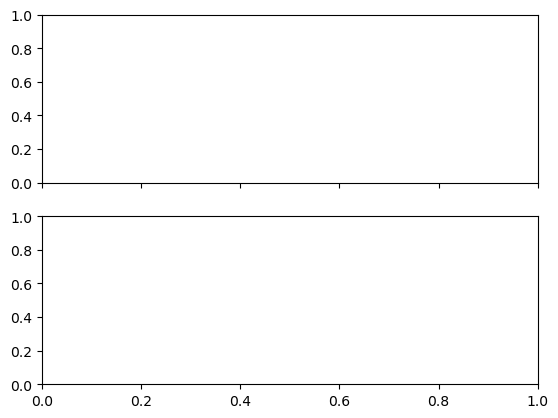

In [70]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 2})


# keys_of_interest = [
#     "nai_min_pur",
#     "tru_min_pur",
#     "opt_min_pur",
#     "nai_max_dmae",
#     "tru_max_dmae",
#     "opt_max_dmae"
# ]

# pur/fid, nai/tru/opt, cal/test, mean/std
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

for i, label in enumerate(('naive','optimal', 'true')):
    x_vis_offset = (1+i/16)
    mu = results_collection[:, i, 0]
    errhi = results_collection[:,i,3] - mu
    errlo = mu - results_collection[:,i,2]
    ax1.errorbar(x = np.array(cnts)*x_vis_offset, y = mu, yerr = (errlo, errhi), fmt=".", label=label)
    ax1.set_xscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('$\min\,P$')

for i, label in enumerate(('naive','optimal', 'true')):
    x_vis_offset = (1+i/16)
    mu = results_collection[:, i+3, 0]
    errhi = results_collection[:,i+3,3] - mu
    errlo = mu - results_collection[:,i+3,2]
    ax2.errorbar(x = np.array(cnts)*x_vis_offset, y = mu, yerr = (errlo, errhi), fmt=".", label=label)
    ax2.set_xscale('log')
# ax2.legend()
ax2.set_xlabel('shots')
ax2.set_ylabel('$\min F$')
ax2.grid()
plt.tight_layout()
plt.show()

#note: 1M = inf

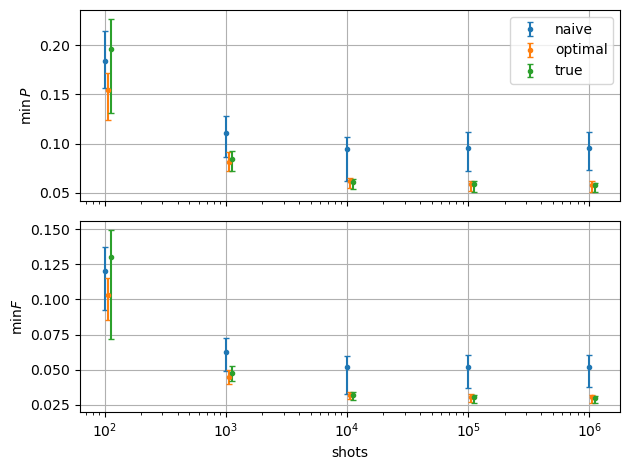

In [ ]:

# pur/fid, nai/tru/opt, cal/test, mean/std
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)

for i, label in enumerate(('naive','optimal', 'true')):
    x_vis_offset = (1+i/16)
    xax = np.array(cnts)
    xax[-1] = 1e6    
    mu = results_collection[:, i, 0]
    errhi = results_collection[:,i,3] - mu
    errlo = mu - results_collection[:,i,2]
    ax1.errorbar(x = xax*x_vis_offset, y = 1-mu, yerr = (errlo, errhi), fmt=".", label=label)
    ax1.set_xscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('$\min\,P$')

for i, label in enumerate(('naive','optimal', 'true')):
    xax = np.array(cnts)
    xax[-1] = 1e6
    x_vis_offset = (1+i/16)
    mu = results_collection[:, i+3, 0]
    errhi = results_collection[:,i+3,3] - mu
    errlo = mu - results_collection[:,i+3,2]
    ax2.errorbar(x = xax*x_vis_offset, y = 1-mu, yerr = (errlo, errhi), fmt=".", label=label)
    ax2.set_xscale('log')
# ax2.legend()
ax2.set_xlabel('shots')
ax2.set_ylabel('$\min F$')
ax2.grid()
plt.tight_layout()
plt.show()
